### Import Library ###

In [10]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from tensorflow import keras
import glob
from tensorflow.keras.preprocessing import image
from keras.layers import Dense, GlobalAveragePooling2D, Conv2D, Conv2DTranspose, LeakyReLU, Reshape, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model, Input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

## 11.1 Prepare Image Data (Real , Fake)

### 11.1.1 Prepare Real Image

In [11]:
# List all filename in art image path
img_size = (32, 32, 3)
filenames = glob.glob("./assets/Art_Image_dataset/*/*/*.jpg")
images = []
for filename in filenames:
  image = cv2.resize(cv2.cvtColor(cv2.imread(filename),cv2.COLOR_BGR2RGB),(32, 32))
  images.append(image)


In [12]:
def norm(arr):  # from [0, 255] to [-1, 1]
  return (arr - 127.5) / 127.5
def renorm(arr): # from [-1, 1] to [0, 255]
  return (arr * 127.5) + 127.5

In [94]:
train_dataset = np.array(images)
train_dataset_norm = norm(train_dataset)

In [95]:
train_dataset_norm

array([[[[-0.86666667, -0.86666667, -0.86666667],
         [-0.88235294, -0.88235294, -0.88235294],
         [-0.89019608, -0.89019608, -0.89019608],
         ...,
         [-1.        , -1.        , -1.        ],
         [-1.        , -1.        , -1.        ],
         [-1.        , -1.        , -1.        ]],

        [[-0.80392157, -0.80392157, -0.80392157],
         [-0.81176471, -0.81176471, -0.81176471],
         [-0.81960784, -0.81960784, -0.81960784],
         ...,
         [-1.        , -1.        , -1.        ],
         [-1.        , -1.        , -1.        ],
         [-1.        , -1.        , -1.        ]],

        [[-0.73333333, -0.73333333, -0.73333333],
         [-0.74117647, -0.74117647, -0.74117647],
         [-0.75686275, -0.75686275, -0.75686275],
         ...,
         [-0.98431373, -0.98431373, -0.98431373],
         [-0.98431373, -0.98431373, -0.98431373],
         [-0.99215686, -0.99215686, -0.99215686]],

        ...,

        [[ 1.        ,  1.        ,  1

In [96]:
train_dataset

array([[[[ 17,  17,  17],
         [ 15,  15,  15],
         [ 14,  14,  14],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[ 25,  25,  25],
         [ 24,  24,  24],
         [ 23,  23,  23],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[ 34,  34,  34],
         [ 33,  33,  33],
         [ 31,  31,  31],
         ...,
         [  2,   2,   2],
         [  2,   2,   2],
         [  1,   1,   1]],

        ...,

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [250, 250, 250],
         [250, 250, 250],
         [249, 249, 249]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [252, 252, 252],
         [252, 252, 252],
         [251, 251, 251]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [253, 253, 253],
        

In [97]:
# Random Seleted images
def generate_real_samples(dataset, n_samples):
  ix = np.random.randint(0, dataset.shape[0],size= n_samples) # random image index
  # retrieve selected index
  x = dataset[ix] # get image from random pick ix
  # generate y = 1 for 'real' class labels
  y = np.ones((n_samples,1)) # y.shape = (n_samples, 1)
  return x,y

In [98]:
n_sample = 4

In [99]:
# Display Random Real Images
x_real, y_real = generate_real_samples(train_dataset_norm, n_sample)

In [100]:
y_real.shape, y_real

((4, 1),
 array([[1.],
        [1.],
        [1.],
        [1.]]))

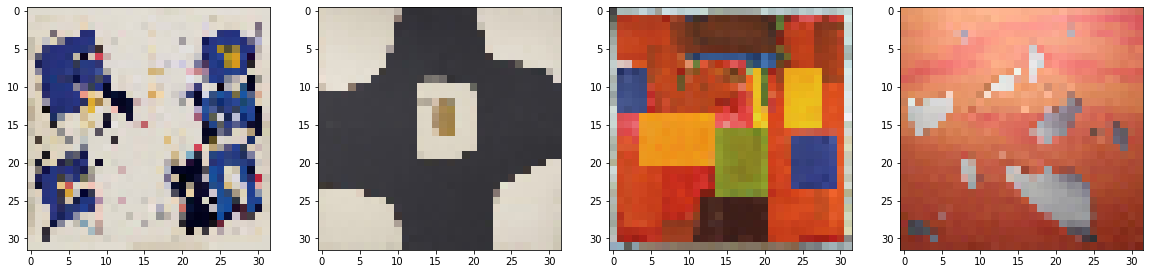

In [101]:
plt.figure(figsize=(20,20))
for i in range(n_sample):
  plt.subplot(1, n_sample, i + 1)
  plt.imshow(renorm(x_real[i]).astype(np.uint8))


### 11.1.2 Prepare Fake Image initial for training discriminator(D)

In [21]:
def generate_fake_samples(n_sample, target_size=(32,32,3)):
  (h,w,c) = target_size
  # generate 1D uniform random numbers in [0, 1]
  x = np.random.randint(2, size=n_sample*h*w*c)
  # rescale x value from [0, 1] to [-1,1]
  x = (x - 0.5) / 0.5 
  x = np.reshape(x, (n_sample, h,w,c))

  y = np.zeros((n_sample, 1))
  return x,y


In [22]:
# generate fake image samples
x_fake,y_fake = generate_fake_samples(n_sample)

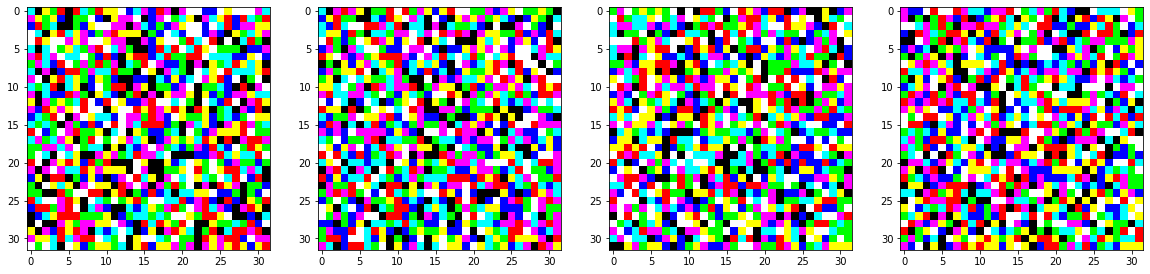

In [102]:
# Display random fake images
plt.figure(figsize=(20,20))
for ix in range(n_sample):
  plt.subplot(1, n_sample, ix + 1)
  plt.imshow(renorm(x_fake[ix]).astype(np.uint8))

## 11.2 Prepare Discriminator Generator Model

### 11.2.1 Create Discriminator Model (D) and Training

In [24]:
# Discriminator Model
def define_discriminator(in_shape=(32,32,3)):
  model = Sequential()
  # normal
  model.add(Conv2D(64, (3, 3), padding='same', input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  # downsample
  model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # downsample
  model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # downsample
  model.add(Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # classifier
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))
  # compile model
  model.compile(loss='binary_crossentropy', optimizer=Adam(
      learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])
  return model


In [25]:
# train the discriminator model
def train_discriminator(model, dataset, n_iter=60, n_batch=128, target_size=(32, 32, 3)):
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for i in range(n_iter):
    # get randomly selected 'real' samples
    x_real, y_real = generate_real_samples(dataset, half_batch)
    # update discriminator on real samples
    _, real_acc = model.train_on_batch(x_real, y_real)
    # generate 'fake' examples
    x_fake, y_fake = generate_fake_samples(half_batch)
    # update discriminator on fake samples
    _, fake_acc = model.train_on_batch(x_fake, y_fake)
    # summarize performance
    print(real_acc, fake_acc)


In [26]:
# define model
d_model = define_discriminator(img_size)

In [27]:
# summarize the model
d_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 256)         2

In [28]:
# Training Discriminator
train_discriminator(d_model, train_dataset_norm, target_size=img_size)

2022-04-19 16:18:47.186662: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


0.53125 0.03125
0.90625 0.234375
0.796875 0.640625
0.5 1.0
0.40625 1.0
0.40625 1.0
0.453125 1.0
0.484375 1.0
0.421875 1.0
0.625 1.0
0.5625 1.0
0.8125 1.0
0.828125 1.0
0.890625 1.0
0.90625 1.0
0.9375 1.0
0.96875 1.0
0.96875 1.0
0.953125 1.0
0.96875 1.0
1.0 1.0
0.984375 1.0
1.0 1.0
0.984375 1.0
1.0 1.0
0.984375 1.0
1.0 1.0
0.984375 1.0
0.984375 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.984375 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0


### 11.2.2 Create Model and pre-train Discriminator (D)

In [29]:
# define the standalone generator model
def define_generator(latent_dim, discr_out=(256, 4, 4)):
  model = Sequential()
  # foundation for 4x4 image
  c, w, h = discr_out
  n_nodes = c * w * h
  model.add(Dense(n_nodes, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((w, h, c)))
  # upsample to 8x8
  model.add(Conv2DTranspose(128, (w, h), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # upsample to 16x16
  model.add(Conv2DTranspose(128, (w, h), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # upsample to 32x32
  model.add(Conv2DTranspose(128, (w, h), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # output layer
  model.add(Conv2D(3, (3, 3), activation='tanh', padding='same'))
  return model


In [30]:
# define the generator model
g_model = define_generator(100)

In [31]:
# summarize the model
g_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 4096)              413696    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        524416    
 nspose)                                                         
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                            

## 11.3 GAN Training and Prediction

### 11.3.1 Create GAN Model (G, D) and Training

In [32]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model


In [33]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input


In [34]:
# update generate fake image using generator prediction
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = np.zeros((n_samples, 1))
	return X, y


In [35]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=60, n_batch=128):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for i in range(n_epochs):
    # enumerate batches over the training set
    for j in range(bat_per_epo):
      # get randomly selected 'real' samples
      x_real, y_real = generate_real_samples(dataset, half_batch)
      # update discriminator model weights
      d_loss1, _ = d_model.train_on_batch(x_real, y_real)
      # generate 'fake' examples
      x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      # update discriminator model weights
      d_loss2, _ = d_model.train_on_batch(x_fake, y_fake)
      # prepare points in latent space as input for the generator
      x_gan = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for the fake samples y = 0 with shape (n_batch, )
      y_gan = np.ones((n_batch,))
      # update the generator via the discriminator's error
      g_loss = gan_model.train_on_batch(x_gan, y_gan)
      print(d_loss1, d_loss2, g_loss)  # summarize loss on this batch
      # evaluate the model performance, every Nepoch
      if (i+1) % 10 == 0:
        summarize_performance(i, g_model, d_model, dataset, latent_dim)


In [36]:
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :, 0])
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	plt.savefig(filename)
	plt.close()


In [37]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
  # prepare real samples
  x_real, y_real = generate_real_samples(dataset, n_samples)
  # evaluate discriminator on real examples
  _, acc_real = d_model.evaluate(x_real, y_real, verbose=0)
  # prepare fake examples
  x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
  # evaluate discriminator on fake examples
  _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
  # summarize discriminator performance
  print(acc_real, acc_fake)
  # save plot
  save_plot(x_fake, epoch)
  # save the generator model tile file
  filename = 'generator_model_%03d.h5' % (epoch+1)
  g_model.save(filename)


In [38]:
# create the gan
gan_model = define_gan(g_model, d_model)
# summarize gan model
gan_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 32, 32, 3)         1466115   
                                                                 
 sequential (Sequential)     (None, 1)                 522497    
                                                                 
Total params: 1,988,612
Trainable params: 1,466,115
Non-trainable params: 522,497
_________________________________________________________________


/Users/littlelunar/.pyenv/versions/3.9.11/envs/image-processing-class/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [39]:
# train model
train(g_model, d_model, gan_model, train_dataset_norm, 100)

0.004420922137796879 1.4953888654708862 0.40221384167671204
0.009212570264935493 1.0669662952423096 0.5127389430999756
0.02879156917333603 0.9314245581626892 0.5594480037689209


KeyboardInterrupt: 

In [88]:
def plot_image(examples, n):
  # plot images
	plt.figure(figsize=(15,15))
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(renorm(examples[i, :, :, :]).astype(np.uint8))
	
	plt.show()


In [89]:
from keras.models import load_model


In [90]:
def generate_latent_points2(latent_dim, n_samples):
	# generate points in the latent space
	x_input = np.random.uniform(-1,1,latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input


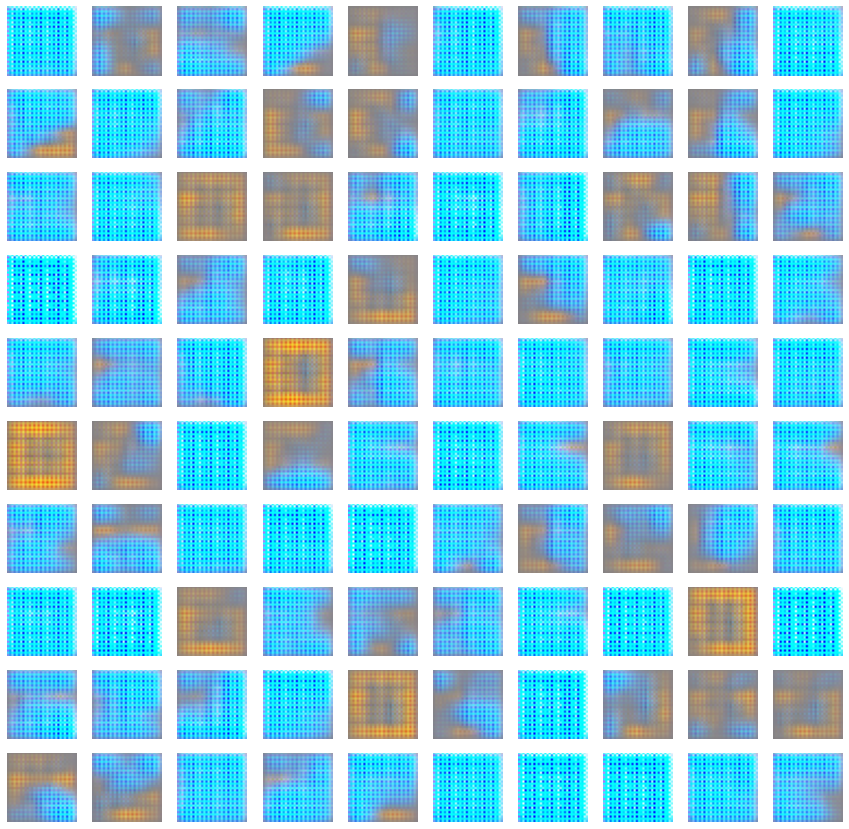

In [91]:
m = load_model("generator_model_010.h5")
latent_point = generate_latent_points2(100, 100)
predict_samples = m.predict(latent_point)
plot_image(predict_samples,10)

In [92]:
predict_samples[i, :, :, :]


array([[[-0.10960442,  0.6236174 ,  0.81509835],
        [ 0.11807658,  0.77207685,  0.9640555 ],
        [-0.26500586,  0.9575037 ,  0.9911034 ],
        ...,
        [ 0.42835757,  0.83968407,  0.9479878 ],
        [ 0.10822897,  0.79360807,  0.8782888 ],
        [ 0.5255564 ,  0.47868842,  0.67603874]],

       [[ 0.13801847, -0.04217152,  0.941766  ],
        [-0.5982927 ,  0.48663074,  0.9939257 ],
        [ 0.53390855,  0.6427607 ,  0.999748  ],
        ...,
        [-0.26489586,  0.65550333,  0.99603   ],
        [ 0.4819665 ,  0.62862986,  0.972944  ],
        [ 0.25800148,  0.48532945,  0.8731137 ]],

       [[-0.45757988,  0.8450183 ,  0.99468195],
        [-0.89181834,  0.89052904,  0.99950314],
        [-0.8867453 ,  0.9987895 ,  0.9999985 ],
        ...,
        [-0.5965125 ,  0.94919217,  0.9990256 ],
        [-0.23817164,  0.97720325,  0.9981571 ],
        [ 0.42898414,  0.64734566,  0.9086828 ]],

       ...,

       [[ 0.05823545, -0.00141143,  0.8748132 ],
        [-0

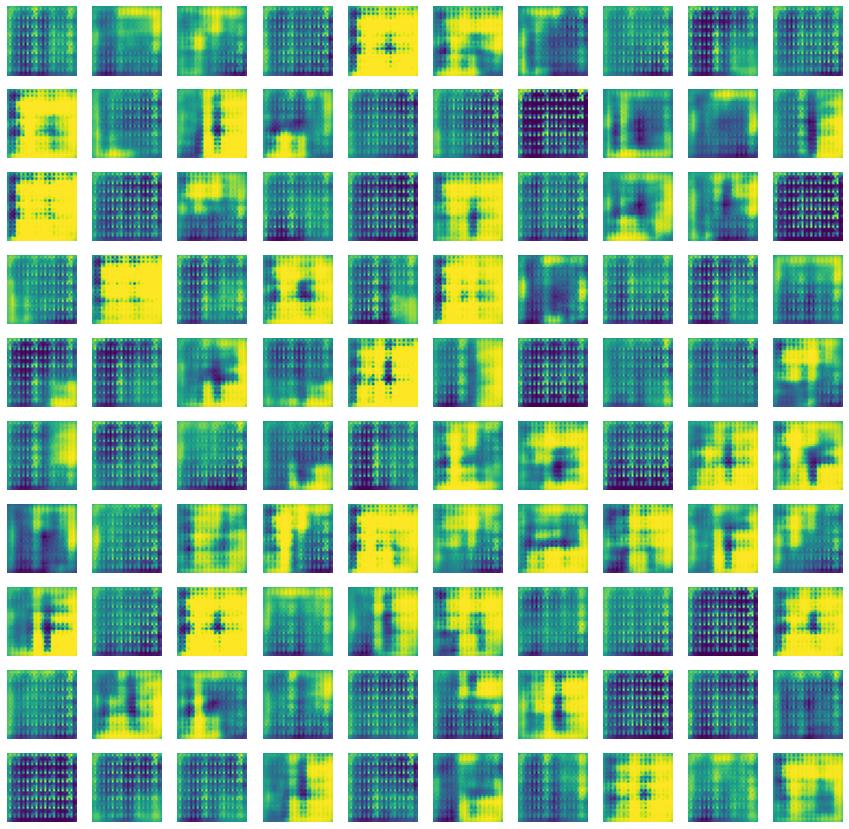

In [54]:
m = load_model("generator_model_020.h5")
latent_point = generate_latent_points2(100, 100)
predict_samples = m.predict(renorm(latent_point))
plot_image(predict_samples,10)

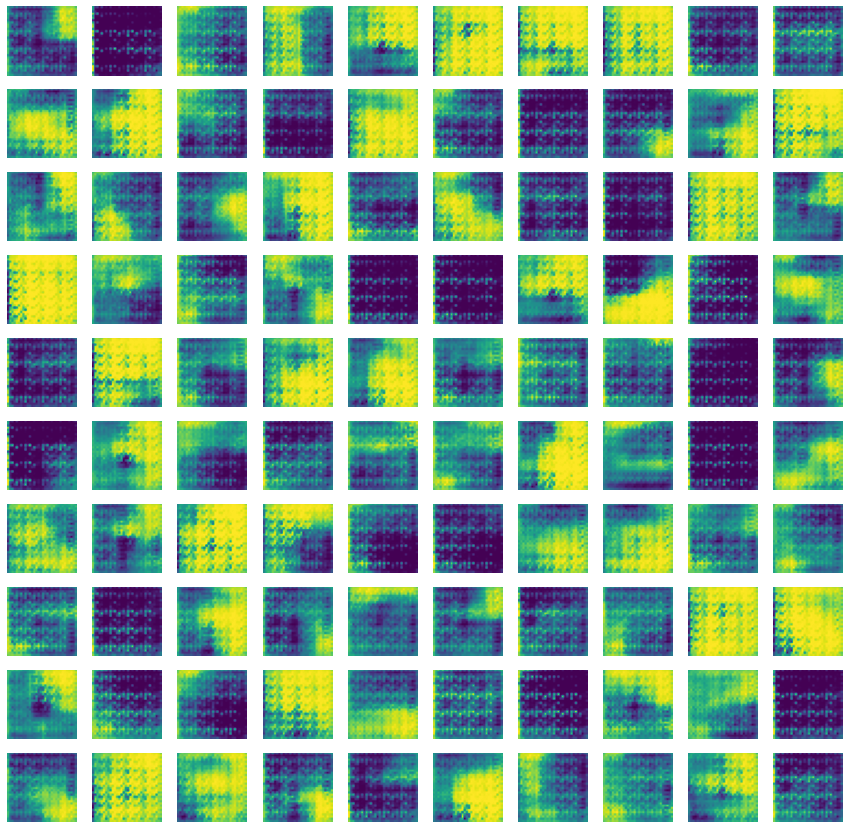

In [55]:
m = load_model("generator_model_030.h5")
latent_point = generate_latent_points2(100, 100)
predict_samples = m.predict(renorm(latent_point))
plot_image(predict_samples,10)

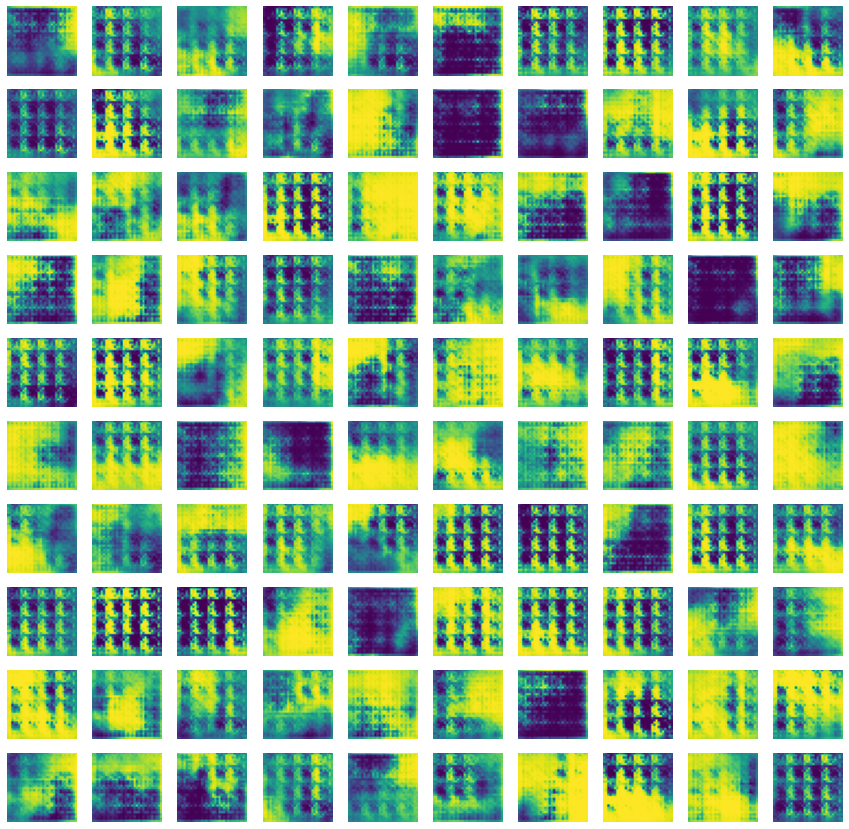

In [56]:
m = load_model("generator_model_040.h5")
latent_point = generate_latent_points2(100, 100)
predict_samples = m.predict(renorm(latent_point))
plot_image(predict_samples,10)

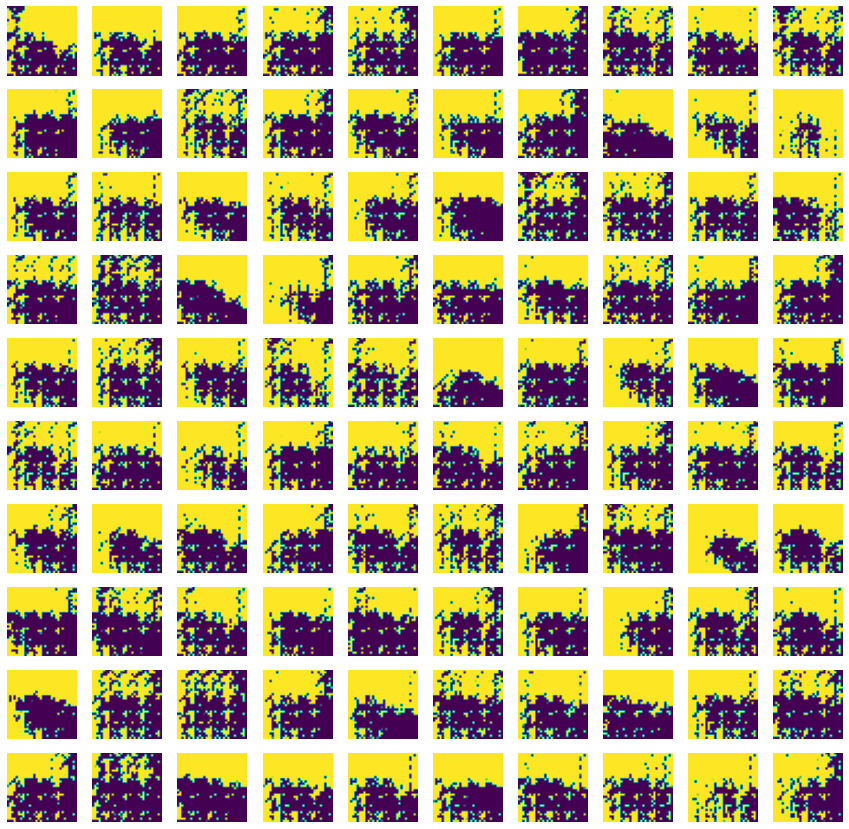

In [73]:
m = load_model("generator_model_050.h5")
latent_point = generate_latent_points2(100, 100)
predict_samples = m.predict(renorm(latent_point))
plot_image(predict_samples,10)

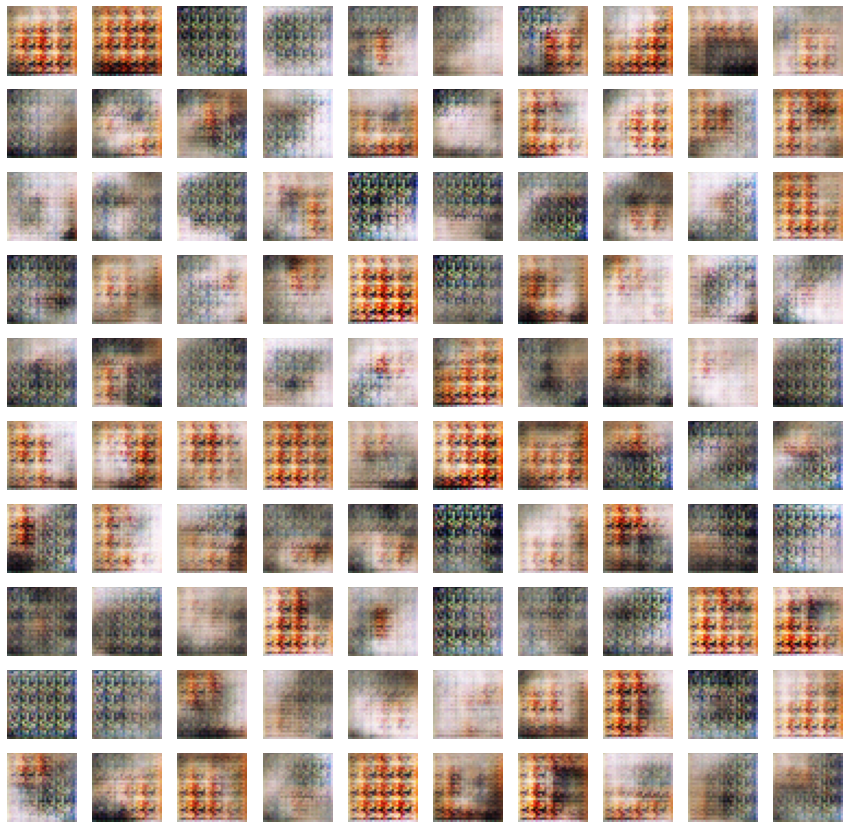

In [93]:
m = load_model("generator_model_060.h5")
latent_point = generate_latent_points2(100, 100)
predict_samples = m.predict(latent_point)
plot_image(predict_samples,10)